# CNN for rock-paper-scissors with Keras/TensorFlow

Date: January 4, 2019

Classification:
- rock
- paper
- scissors

## Preparing data set for CNN

In [40]:
DATA_FOLDER = '../thermography/data/'

FILES = 45
TRAINING_FILES = 30 
TEST_FILES = FILES - TRAINING_FILES

In [41]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import time
import random
import os
import sklearn.preprocessing as pp

In [42]:
import glob

data_files = glob.glob(DATA_FOLDER+'*.csv')
class_labels = []

for file in data_files:
    label = file.split('-')[0].replace('\\', '/').split('/')[-1]
    if label not in class_labels:
        class_labels.append(label)

data_set = {}

class_number = 0

for label in class_labels:
    files = glob.glob(DATA_FOLDER+'{}-*.csv'.format(label))
    random.shuffle(files)
    data_set[label] = (files[:TRAINING_FILES], files[TRAINING_FILES:FILES], class_number)
    class_number += 1

training_set = []
test_set = []

for k, v in data_set.items():
    files = v[0]
    class_number = v[2]
    for file in files:
        with open(file) as f:
            data = np.array(f.read().split(',')).astype(float)
            training_set.append((pp.scale(data), class_number))
    files = v[1]
    for file in files:
        with open(file) as f:
            data = np.array(f.read().split(',')).astype(float)
            test_set.append((pp.scale(data), class_number))
random.shuffle(training_set)
random.shuffle(test_set)

class_labels = [None for _ in range(len(data_set))]

# Class number and class labels
for k,v in data_set.items():
    print('{}: {}'.format(v[2],k))
    class_labels[v[2]] = k
    
import yaml
with open(DATA_FOLDER+'class_labels.yaml', 'w') as f:
    yaml.dump(class_labels, f)

0: paper
1: rock
2: scissors


array([[-0.52399373, -0.24882984,  0.50787085,  2.50280905,  2.43401807,
         2.33083161,  1.1269896 , -0.31762082],
       [-0.24882984, -0.52399373, -0.07685241,  2.15885418,  2.50280905,
         1.47094446,  0.09512502, -0.76476214],
       [-0.52399373, -0.66157568, -0.07685241,  1.81489932,  0.85182571,
         1.29896703, -0.52399373, -0.52399373],
       [-0.52399373, -0.52399373,  0.16391599,  1.40215349,  0.16391599,
         1.74610835, -0.42080728, -0.52399373],
       [-0.8679486 , -0.52399373,  0.09512502,  0.95501217, -0.31762082,
         1.40215349, -0.24882984, -0.52399373],
       [-0.8679486 , -0.76476214, -0.52399373,  0.02633404, -0.52399373,
         0.50787085, -0.07685241, -0.66157568],
       [-1.00553054, -0.76476214, -0.76476214, -0.76476214, -0.42080728,
        -0.52399373, -0.66157568, -0.76476214],
       [-0.93673957, -0.93673957, -0.93673957, -0.93673957, -0.66157568,
        -0.76476214, -0.8679486 , -0.93673957]])

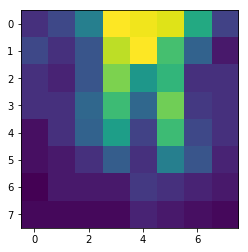

In [43]:
train_data, train_labels = [], []
test_data, test_labels = [], []
for img, label in training_set:
    train_data.append(img)
    train_labels.append(label)
for img, label in test_set:
    test_data.append(img)
    test_labels.append(label)
train_data = np.array(train_data).reshape((TRAINING_FILES*len(class_labels), 8, 8, 1))
train_labels = np.array(train_labels, dtype='uint8')
test_data = np.array(test_data).reshape((TEST_FILES*len(class_labels), 8, 8, 1))
test_lables = np.array(test_labels, dtype='uint8')
#train_data.shape

from keras.utils import to_categorical

train_labels=to_categorical(train_labels)
test_labels=to_categorical(test_labels)

plt.imshow(train_data[12,:,:,0])
train_data[12,:,:,0]

### CNN model

In [44]:
from keras import layers
from keras import models

model = models.Sequential()

model.add(layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(8, 8, 1)))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(class_labels), activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 8, 8, 16)          160       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 32)          4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 128)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 387       
Total para

In [45]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

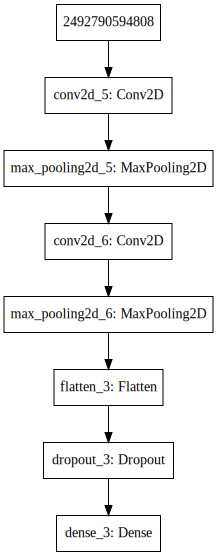

In [46]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Training CNN

In [47]:
EPOCHS = 80
history = model.fit(train_data, train_labels, epochs=EPOCHS, validation_data=(test_data, test_labels))

Train on 90 samples, validate on 45 samples
Epoch 1/80
90/90 [==============================] - 1s 7ms/step - loss: 1.0449 - acc: 0.4444 - val_loss: 1.0174 - val_acc: 0.5111
Epoch 2/80
90/90 [==============================] - 0s 364us/step - loss: 1.0780 - acc: 0.3778 - val_loss: 0.9935 - val_acc: 0.5333
Epoch 3/80
90/90 [==============================] - 0s 382us/step - loss: 0.9191 - acc: 0.6333 - val_loss: 0.9608 - val_acc: 0.6444
Epoch 4/80
90/90 [==============================] - 0s 325us/step - loss: 0.9337 - acc: 0.5222 - val_loss: 0.9408 - val_acc: 0.6000
Epoch 5/80
90/90 [==============================] - 0s 353us/step - loss: 0.8899 - acc: 0.6667 - val_loss: 0.9193 - val_acc: 0.6667
Epoch 6/80
90/90 [==============================] - 0s 292us/step - loss: 0.8697 - acc: 0.6556 - val_loss: 0.9048 - val_acc: 0.6222
Epoch 7/80
90/90 [==============================] - 0s 270us/step - loss: 0.8363 - acc: 0.7222 - val_loss: 0.8886 - val_acc: 0.6444
Epoch 8/80
90/90 [================

90/90 [==============================] - 0s 198us/step - loss: 0.2026 - acc: 0.9333 - val_loss: 0.3483 - val_acc: 0.8889
Epoch 63/80
90/90 [==============================] - 0s 176us/step - loss: 0.1865 - acc: 0.9778 - val_loss: 0.3319 - val_acc: 0.9556
Epoch 64/80
90/90 [==============================] - 0s 182us/step - loss: 0.1763 - acc: 0.9556 - val_loss: 0.3303 - val_acc: 0.9333
Epoch 65/80
90/90 [==============================] - 0s 187us/step - loss: 0.1580 - acc: 1.0000 - val_loss: 0.3235 - val_acc: 0.9333
Epoch 66/80
90/90 [==============================] - 0s 176us/step - loss: 0.1840 - acc: 0.9667 - val_loss: 0.3228 - val_acc: 0.9333
Epoch 67/80
90/90 [==============================] - 0s 176us/step - loss: 0.1813 - acc: 0.9444 - val_loss: 0.3377 - val_acc: 0.9111
Epoch 68/80
90/90 [==============================] - 0s 226us/step - loss: 0.1543 - acc: 0.9667 - val_loss: 0.3293 - val_acc: 0.8889
Epoch 69/80
90/90 [==============================] - 0s 292us/step - loss: 0.1522

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


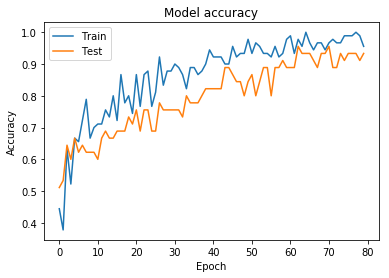

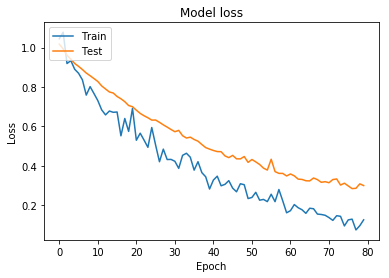

In [48]:
print(history.history.keys())

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Save the model

In [49]:
import datetime

dt = datetime.datetime.today().strftime('%Y%m%d%H%M%S')
filename = 'cnn_for_rock_paper_scissors{}.h5'.format(dt)
model.save(filename)

## Load the model

In [50]:
del model
model = models.load_model(filename)

## Confirmation

In [51]:
import numpy as np
import matplotlib.pyplot as plt
train_data.shape

(90, 8, 8, 1)

In [52]:
layer_outputs = [layer.output for layer in model.layers]
#layer_outputs

In [53]:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(test_data)
#activations[0][0,:,:,0].shape

In [54]:
class_labels

['paper', 'rock', 'scissors']

In [55]:
(activations[-1][:10]*100).astype(int)

array([[17,  0, 81],
       [ 0,  2, 97],
       [ 0,  2, 97],
       [99,  0,  0],
       [82, 12,  4],
       [96,  1,  1],
       [96,  3,  0],
       [70, 26,  3],
       [97,  0,  1],
       [ 3, 31, 65]])

In [56]:
test_labels[:10].astype(int)

array([[0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1]])

In [57]:
def plot_layer(activations, sample, layer):
    a = activations[layer].shape
    rows = int(a[3]/4)
    fig, axarr = plt.subplots(rows, 4, figsize=[20,15])
    for i in range(a[3]):
        row = int(i/4)
        x, y = row, i-4*row
        axarr[x, y].imshow(activations[layer][sample, :, :, i])
        axarr[x, y].set_xticks([])
        axarr[x, y].set_yticks([])

'paper'

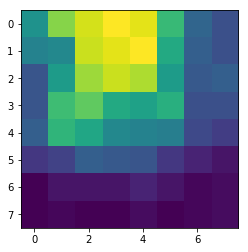

In [58]:
image_number = 10

plt.imshow(test_data[image_number,:,:,0])
class_labels[np.argmax(test_labels[image_number])]

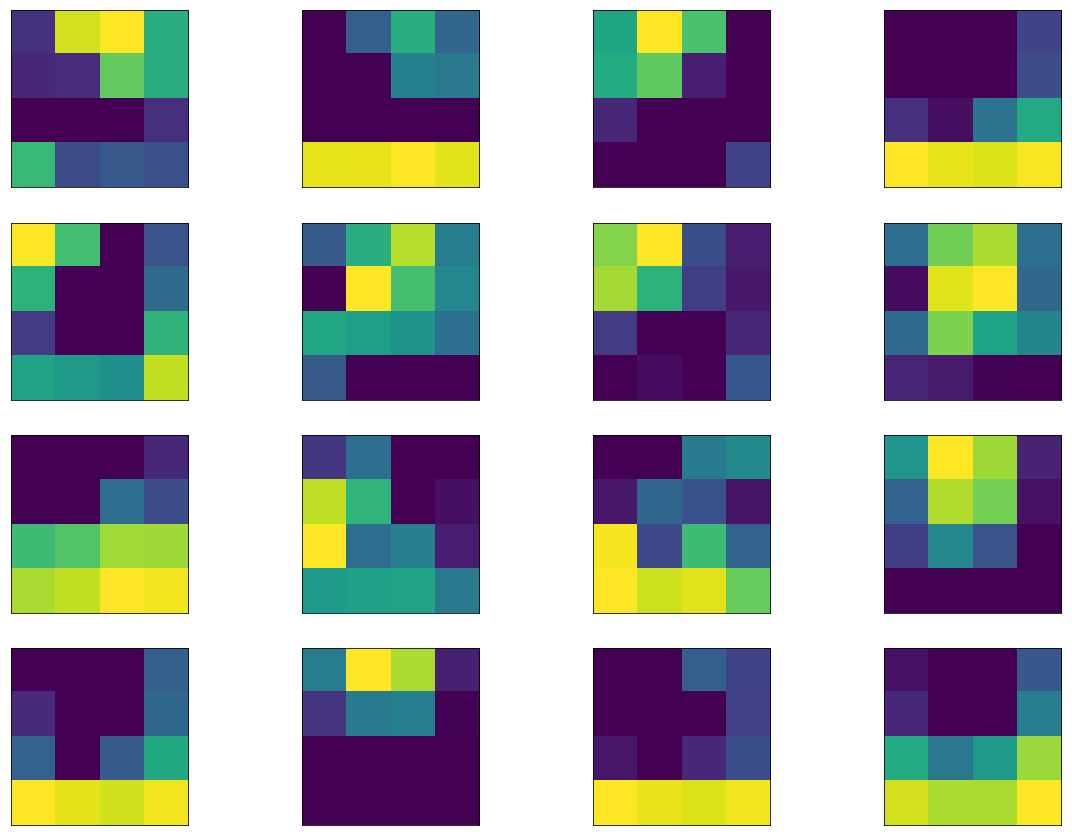

In [59]:
plot_layer(activations, image_number, 1)

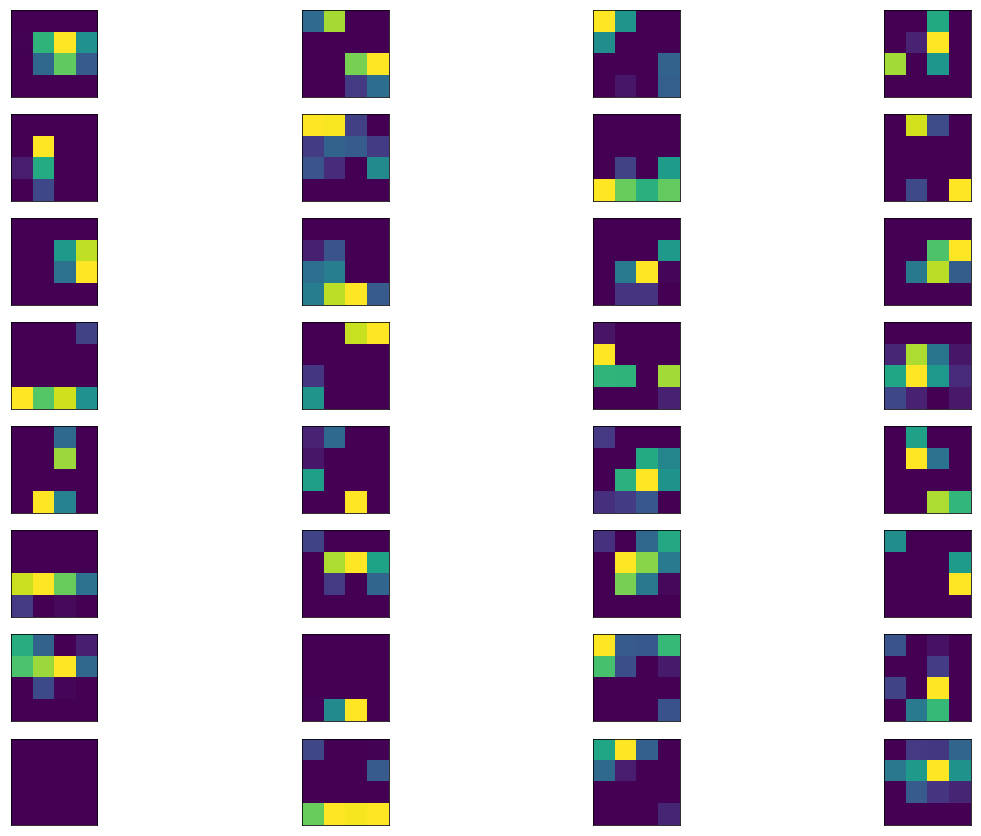

In [60]:
plot_layer(activations, image_number, 2)